In [4]:
import time
import os
import sys
import csv
import numpy as np
import glob
#import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from progressbar import ProgressBar
import pandas as pd
import pickle
import h5py
import copy

from collections import defaultdict
import progressbar



from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn. metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
import jenkspy
from matplotlib.dates import MonthLocator, DateFormatter



from sklearn.utils import shuffle


#from sklearn.externals import joblib
import joblib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


af_to_104m3 = 0.123348


In [5]:
def ProcessData(df, sim, test_yr):
    
    #Input optimial features from XGBoost_WSM_Tuning
    LittleDell_Percent_Full = ['Month', 'Dell_Streamflow', 'Mtn_Dell_Percent_Full_Initial', 'LittleDell_Percent_Full_Initial']
    
    Mtn_Dell_Percent_Full =  ['SLCDPU_Surface_Supplies', 'Dell_Streamflow', 'Lambs_Streamflow',
                              'SLCDPU_GW_Initial', 'Mtn_Dell_Percent_Full_Initial']
    
     
    SLCDPU_GW = ['Dell_Streamflow', 'SLCDPU_Prod_Demands', 'SLCDPU_GW_Initial', 
                 'Mtn_Dell_Percent_Full_Initial', 'LittleDell_Percent_Full_Initial']
    
    SLCDPU_DC_Water_Use = ['BCC_Streamflow', 'SLCDPU_Prod_Demands', 'SLCDPU_DC_Water_Use_Initial', 
                           'Mtn_Dell_Percent_Full_Initial', 'LittleDell_Percent_Full_Initial']
    #These go with the test models
    #LittleDell_Percent_Full = ['Month', 'Dell_Streamflow', 'LittleDell_Percent_Full_Initial']
    
   # Mtn_Dell_Percent_Full = ['Dell_Streamflow', 'CC_Streamflow', 'SLCDPU_GW_Initial', 'Mtn_Dell_Percent_Full_Initial']
    
    #SLCDPU_GW = ['LCC_Streamflow', 'Dell_Streamflow', 'CC_Streamflow', 'SLCDPU_Prod_Demands', 'SLCDPU_DC_Water_Use_Initial',
     #            'SLCDPU_GW_Initial', 'Mtn_Dell_Percent_Full_Initial', 'LittleDell_Percent_Full_Initial']
    
    #SLCDPU_DC_Water_Use = ['DOY', 'BCC_Streamflow', 'Dell_Streamflow', 'Lambs_Streamflow', 'SLCDPU_Prod_Demands',
     #                      'SLCDPU_DC_Water_Use_Initial', 'Mtn_Dell_Percent_Full_Initial', 'LittleDell_Percent_Full_Initial']
   #put into dictionary to loop through
    feat = {
            'LittleDell_Percent_Full':LittleDell_Percent_Full,
            'Mtn_Dell_Percent_Full':Mtn_Dell_Percent_Full,
            'SLCDPU_GW': SLCDPU_GW,
            'SLCDPU_DC_Water_Use': SLCDPU_DC_Water_Use   
            }
    
    #make a DF with some additional features (from GS)
    data = copy.deepcopy(df)
    dflen = len(data[sim])
    months = []
    days = []
    years = []
    data[sim]['DOY'] = 0
    for t in range(0,dflen,1):
        y = data[sim]['Time'][t].year
        m = data[sim]['Time'][t].month
        d = data[sim]['Time'][t].day
        months.append(m)
        days.append(d)
        years.append(y)
        
        data[sim]['DOY'].iloc[t] = data[sim]['Time'].iloc[t].day_of_year
    
    years = list( dict.fromkeys(years) )  
    #remove yr 2000  and 2022 as it is not a complete year
    years = years[1:-1]
    data[sim]['Month'] = months
    data[sim]['Day'] = days
    data[sim].index = data[sim]['Time']

    
    
    #input each year's initial reservoir conditions./ previous timestep conditions.
    data[sim]['Mtn_Dell_Percent_Full_Initial'] = 0
    data[sim]['LittleDell_Percent_Full_Initial'] = 0
    data[sim]['SLCDPU_GW_Initial'] = 0
    data[sim]['SLCDPU_DC_Water_Use_Initial'] = 0
    timelen = len(data[sim])
    for t in range(0,timelen, 1):
        data[sim]['Mtn_Dell_Percent_Full_Initial'].iloc[t] = data[sim]['Mtn_Dell_Percent_Full'].iloc[(t-1)]
        data[sim]['LittleDell_Percent_Full_Initial'].iloc[t] = data[sim]['LittleDell_Percent_Full'].iloc[(t-1)]
        data[sim]['SLCDPU_GW_Initial'].iloc[t] = data[sim]['SLCDPU_GW'].iloc[(t-1)]
        data[sim]['SLCDPU_DC_Water_Use_Initial'].iloc[t] = data[sim]['SLCDPU_DC_Water_Use'].iloc[(t-1)]

        
    #make an aggregated streamflow metric
    data[sim]['SLCDPU_Surface_Supplies'] = data[sim]['BCC_Streamflow']+data[sim]['LCC_Streamflow']+data[sim]['CC_Streamflow']+data[sim]['Dell_Streamflow']+data[sim]['Lambs_Streamflow']

    #Make dictionary of acutal features
    features = { 'LittleDell_Percent_Full':data[sim][feat['LittleDell_Percent_Full']],
            'Mtn_Dell_Percent_Full':data[sim][feat['Mtn_Dell_Percent_Full']],
            'SLCDPU_GW': data[sim][feat['SLCDPU_GW']],
            'SLCDPU_DC_Water_Use': data[sim][feat['SLCDPU_DC_Water_Use']]  
               }  
    #set up Targets
    targ = ['SLCDPU_GW', 'Mtn_Dell_Percent_Full', 'LittleDell_Percent_Full','SLCDPU_DC_Water_Use']
    targets = data[sim][targ]
    
    for i in features:
        features[i] = features[i].loc[str(test_yr)+'-4-1':str(test_yr)+'-10-30']
    
    Hist_targs = targets.loc[:str(test_yr)+'-3-31'].copy()
    targets = targets.loc[str(test_yr)+'-4-1':str(test_yr)+'-10-30']

    return features, targets, Hist_targs




#make batch xgboost class-structured model, This is the pre-evolutionary algorithm model
#increasing the number of trees (num_round help model accuracy but takes longer. adjust as nec)
class XGB_model():
    def __init__(self,param):
        self.param=param
        self.num_round=param['num_boost_round']
    def fit(self,X,y,targ):
        start_time = time.time()      
        pbar=ProgressBar()
        print('Model Training')
        y = y[targ]
        feature_names = list(X.columns)
        dtrain = xgb.DMatrix(np.array(X), label=np.array(y),feature_names=feature_names)
        model = xgb.Booster(self.param, [dtrain])
        model = xgb.train(self.param,dtrain,num_boost_round=self.num_round, xgb_model=model)

        c_time = round(time.time() - start_time,2)
        print('Calibration time', round(c_time), 's')
        print('Saving Model')
        #adjust this to match changing models
        pickle.dump(model, open("Models/XGBoost_"+targ+".dat", "wb"))   
        #pickle.dump(model, open("Models/XGBoost_"+targ+"_Test.dat", "wb"))   

        self.model_=model
    def predict(self,X, model):
        self.model_=model
        dtest=xgb.DMatrix(X)
        return self.model_.predict(dtest) 
    
    
    
    
def ScenarioPredictor(features, targets, clim):   
    #Order of prediction could be important. Goes mtn dell, little dell, GW, DC
    af_to_104m3 = 0.123348

    #Set up the target labels
    #Mountain Dell
    MDell = 'Mtn_Dell_Percent_Full'
    MDell_Pred = MDell+'_Pred'
    MDell_Pred_Rol = MDell_Pred+'_Rolling'
    MDell_Initial = MDell+'_Initial'
    
    #Little Dell
    LDell = 'LittleDell_Percent_Full'
    LDell_Pred = LDell+'_Pred'
    LDell_Pred_Rol = LDell_Pred+'_Rolling'
    LDell_Initial = LDell+'_Initial'
    
    #GW
    GW = 'SLCDPU_GW'
    GW_Pred = GW+'_Pred'
    GW_Pred_Rol = GW_Pred+'_Rolling'
    GW_Initial = GW+'_Initial'
    
    #GW
    DC = 'SLCDPU_DC_Water_Use'
    DC_Pred = DC+'_Pred'
    DC_Pred_Rol = DC_Pred+'_Rolling'
    DC_Initial = DC+'_Initial'
      
    #Grab features/targets for the respective target    
    MDell_feat = copy.deepcopy(features[clim][MDell])
    MDell_targ = copy.deepcopy(targets[clim][MDell])
    
    LDell_feat = copy.deepcopy(features[clim][LDell])
    LDell_targ = copy.deepcopy(targets[clim][LDell])
    
    GW_feat = copy.deepcopy(features[clim][GW])
    GW_targ = copy.deepcopy(targets[clim][GW])
    
    DC_feat = copy.deepcopy(features[clim][DC])
    DC_targ = copy.deepcopy(targets[clim][DC])
    
    #Make predictions with the model, load model from XGBoost_WSM_Tuning
    MDell_model = pickle.load(open("Models/XGBoost_"+MDell+".dat", "rb"))
    LDell_model = pickle.load(open("Models/XGBoost_"+LDell+".dat", "rb"))
    GW_model = pickle.load(open("Models/XGBoost_"+GW+".dat", "rb"))
    DC_model = pickle.load(open("Models/XGBoost_"+DC+".dat", "rb"))
    
    #MDell_model = pickle.load(open("Models/XGBoost_"+MDell+"_Test.dat", "rb"))
    #LDell_model = pickle.load(open("Models/XGBoost_"+LDell+"_Test.dat", "rb"))
    #GW_model = pickle.load(open("Models/XGBoost_"+GW+"_Test.dat", "rb"))
    #DC_model = pickle.load(open("Models/XGBoost_"+DC+"_Test.dat", "rb"))
    
    
    
    
    
    start_time = time.time()  
    #since the previous timestep is being used, we need to predict this value
    #Mtn dell
    MDell_predict = []
    MDell_col = MDell_feat.columns
    
    #lil Dell
    LDell_predict = []
    LDell_col = LDell_feat.columns
    
    #GW
    GW_predict = []
    GW_col = GW_feat.columns
    
    #GW
    DC_predict = []
    DC_col = DC_feat.columns
    
    #Make Predictions by row, update DF intitials to make new row prediction based on the current
    for i in range(0,(len(LDell_feat)-1),1):
        #MOuntain Dell
        MDell_t_feat = np.array(MDell_feat.iloc[i])
        MDell_t_feat = MDell_t_feat.reshape(1,len(MDell_t_feat))
        MDell_t_feat = pd.DataFrame(MDell_t_feat, columns = MDell_col)
        M = XGB_model.predict(MDell_model, MDell_t_feat, MDell_model)
        
        #Little Dell
        LDell_t_feat = np.array(LDell_feat.iloc[i])
        LDell_t_feat = LDell_t_feat.reshape(1,len(LDell_t_feat))
        LDell_t_feat = pd.DataFrame(LDell_t_feat, columns = LDell_col)
        L = XGB_model.predict(LDell_model, LDell_t_feat, LDell_model)
        
        #GW
        GW_t_feat = np.array(GW_feat.iloc[i])
        GW_t_feat = GW_t_feat.reshape(1,len(GW_t_feat))
        GW_t_feat = pd.DataFrame(GW_t_feat, columns = GW_col)
        G = XGB_model.predict(GW_model, GW_t_feat, GW_model)
        
        #DC
        DC_t_feat = np.array(DC_feat.iloc[i])
        DC_t_feat = DC_t_feat.reshape(1,len(DC_t_feat))
        DC_t_feat = pd.DataFrame(DC_t_feat, columns = DC_col)
        D = XGB_model.predict(DC_model, DC_t_feat, DC_model)
        
        
        
        
        #This updates each DF with the predictions
        #Mountain Dell Features
        if LDell_Initial in MDell_col:
            MDell_feat[LDell_Initial].iloc[(i+1)] = L
        
        if MDell_Initial in MDell_col:
            MDell_feat[MDell_Initial].iloc[(i+1)] = M
            
        if GW_Initial in MDell_col:
            MDell_feat[GW_Initial].iloc[(i+1)] = G
            
        if DC_Initial in MDell_col:
            MDell_feat[DC_Initial].iloc[(i+1)] = D
            
        #Little Dell Features
        if LDell_Initial in LDell_col:
            LDell_feat[LDell_Initial].iloc[(i+1)] = L
        
        if MDell_Initial in LDell_col:
            LDell_feat[MDell_Initial].iloc[(i+1)] = M
            
        if GW_Initial in LDell_col:
            LDell_feat[GW_Initial].iloc[(i+1)] = G
            
        if DC_Initial in LDell_col:
            LDell_feat[DC_Initial].iloc[(i+1)] = D
            
        #Gw Features
        if LDell_Initial in GW_col:
            GW_feat[LDell_Initial].iloc[(i+1)] = L
        
        if MDell_Initial in GW_col:
            GW_feat[MDell_Initial].iloc[(i+1)] = M
            
        if GW_Initial in GW_col:
            GW_feat[GW_Initial].iloc[(i+1)] = G
            
        if DC_Initial in GW_col:
            GW_feat[DC_Initial].iloc[(i+1)] = D
            
        #DC Features
        if LDell_Initial in DC_col:
            DC_feat[LDell_Initial].iloc[(i+1)] = L
        
        if MDell_Initial in DC_col:
            DC_feat[MDell_Initial].iloc[(i+1)] = M
            
        if GW_Initial in DC_col:
            DC_feat[GW_Initial].iloc[(i+1)] = G
            
        if DC_Initial in DC_col:
            DC_feat[DC_Initial].iloc[(i+1)] = D
            
            
            
      #Append predictions      
        MDell_predict.append(M[0])
        LDell_predict.append(L[0])
        GW_predict.append(G[0])
        DC_predict.append(D[0])
        
        
    #need to manually add one more prediction
    MDell_predict.append(MDell_predict[-1])
    LDell_predict.append(LDell_predict[-1])
    GW_predict.append(GW_predict[-1])
    DC_predict.append(DC_predict[-1])

    
    #Use this line for PCA
    c_time = round(time.time() - start_time,8)
    print('prediction time', round(c_time), 's')

    #Analyze model performance
    #Add Little Dell
    Analysis = pd.DataFrame(LDell_targ, columns = [LDell])
    Analysis[LDell_Pred] = LDell_predict
    #non-zero values cannot occur
    Analysis[LDell_Pred][Analysis[LDell_Pred]<0] = 0
    Analysis[LDell_Pred_Rol] = Analysis[LDell_Pred].rolling(5).mean()

    Analysis[LDell_Pred_Rol] = Analysis[LDell_Pred_Rol].interpolate(method='linear',
                                                   limit_direction='backward', 
                                                   limit=5)
    
    #Add Mountain Dell
    Analysis[MDell] = MDell_targ
    Analysis[MDell_Pred] = MDell_predict
    #non-zero values cannot occur
    Analysis[MDell_Pred][Analysis[MDell_Pred]<0] = 0
    Analysis[MDell_Pred_Rol] = Analysis[MDell_Pred].rolling(5).mean()

    Analysis[MDell_Pred_Rol] = Analysis[MDell_Pred_Rol].interpolate(method='linear',
                                                   limit_direction='backward', 
                                                   limit=5)
    
    #Add GW
    Analysis[GW] = np.float32(GW_targ)*af_to_104m3
    Analysis[GW_Pred] = np.float32(GW_predict)*af_to_104m3
    #non-zero values cannot occur
    Analysis[GW_Pred][Analysis[GW_Pred]<0] = 0
    Analysis[GW_Pred_Rol] = Analysis[GW_Pred].rolling(5).mean()

    Analysis[GW_Pred_Rol] = Analysis[GW_Pred_Rol].interpolate(method='linear',
                                                   limit_direction='backward', 
                                                   limit=5)
    
    #Add DC
    Analysis[DC] = np.float32(DC_targ)*af_to_104m3
    Analysis[DC_Pred] = np.float32(DC_predict)*af_to_104m3
    #non-zero values cannot occur
    Analysis[DC_Pred][Analysis[DC_Pred]<0] = 0
    Analysis[DC_Pred_Rol] = Analysis[DC_Pred].rolling(5).mean()

    Analysis[DC_Pred_Rol] = Analysis[DC_Pred_Rol].interpolate(method='linear',
                                                   limit_direction='backward', 
                                                   limit=5)
    
    print('Predictions Complete') 
    
    #Changes 0 values to 1 to avoid inf
    Analysis[GW].loc[Analysis[GW]<.05] =0.05
    Analysis[DC].loc[Analysis[DC]<.05] =.05
    
    #input physical limitations to components
    Analysis[GW_Pred].loc[Analysis[GW_Pred]<0] =0
    Analysis[DC_Pred].loc[Analysis[DC_Pred]<0.05] =0.05
    Analysis[MDell_Pred].loc[Analysis[MDell_Pred]<25] =25
    Analysis[LDell_Pred].loc[Analysis[LDell_Pred]<10] =10
    
    
    
    #Calculate RMSE
    RMSE_LDell = mean_squared_error(Analysis[LDell],Analysis[LDell_Pred], squared=False)
    RMSE_MDell = mean_squared_error(Analysis[MDell],Analysis[MDell_Pred], squared=False)
    RMSE_GW = mean_squared_error(Analysis[GW],Analysis[GW_Pred], squared=False)
    RMSE_DC = mean_squared_error(Analysis[DC],Analysis[DC_Pred], squared=False)
    
    #Calculate MAPE
    MAPE_LDell = abs((Analysis[LDell]-Analysis[LDell_Pred])/Analysis[LDell])*100
    MAPE_MDell = abs((Analysis[MDell]-Analysis[MDell_Pred])/Analysis[MDell])*100
    MAPE_GW = abs((Analysis[GW]-Analysis[GW_Pred])/Analysis[GW])*100
    MAPE_DC = abs((Analysis[DC]-Analysis[DC_Pred])/Analysis[DC])*100
    
    MAPE_LDell[MAPE_LDell> 100] = 100
    MAPE_MDell[MAPE_MDell> 100] = 100
    MAPE_GW[MAPE_GW> 100] = 100
    MAPE_DC[MAPE_DC> 100] = 100
    
    MAPE_LDell= np.mean(MAPE_LDell)
    MAPE_MDell= np.mean(MAPE_MDell)
    MAPE_GW= np.mean(MAPE_GW)
    MAPE_DC= np.mean(MAPE_DC)
    
    #Calculate R2
    R2_LDell = r2_score(Analysis[LDell],Analysis[LDell_Pred])
    R2_MDell = r2_score(Analysis[MDell],Analysis[MDell_Pred])
    R2_GW = r2_score(Analysis[GW],Analysis[GW_Pred])
    R2_DC = r2_score(Analysis[DC],Analysis[DC_Pred])
    
    
    
    print(clim, 'Mountain Dell RMSE: ', RMSE_MDell, '%, MAPE: ', MAPE_MDell, '%, R2: ', R2_MDell)
    print(clim, 'Little Dell RMSE: ', RMSE_LDell, '%, MAPE: ', MAPE_LDell,'%, R2: ', R2_LDell)
    print(clim, 'GW Extraction RMSE: ', RMSE_GW, 'x10^4 m^3, MAPE: ', MAPE_GW,'%, R2: ', R2_GW)
    print(clim, 'DC Extraction RMSE: ', RMSE_DC, 'x10^4 m^3, MAPE: ', MAPE_DC,'%, R2: ', R2_DC)
   
    
    return Analysis




def PredictionPerformancePlot(Analysis, clim):
    
    #Set up the target labels
    #Mountain Dell
    MDell = 'Mtn_Dell_Percent_Full'
    MDell_Pred = MDell+'_Pred'
    MDell_Pred_Rol = MDell_Pred+'_Rolling'
    MDell_Initial = MDell+'_Initial'
    
    #Little Dell
    LDell = 'LittleDell_Percent_Full'
    LDell_Pred = LDell+'_Pred'
    LDell_Pred_Rol = LDell_Pred+'_Rolling'
    LDell_Initial = LDell+'_Initial'
    
    #GW
    GW = 'SLCDPU_GW'
    GW_Pred = GW+'_Pred'
    GW_Pred_Rol = GW_Pred+'_Rolling'
    GW_Initial = GW+'_Initial'
    
    #GW
    DC = 'SLCDPU_DC_Water_Use'
    DC_Pred = DC+'_Pred'
    DC_Pred_Rol = DC_Pred+'_Rolling'
    DC_Initial = DC+'_Initial'

    #predicted and observed
    labelsize = 14

    # better control over ax
    fig, ax = plt.subplots(4, 2)
    fig.set_size_inches(20,14)
    
    #Define max values
    max_LDell = max(max(Analysis[LDell]), max(Analysis[LDell_Pred]))*1.2
    max_MDell = max(max(Analysis[MDell]), max(Analysis[MDell_Pred]))*1.2
    max_GW = max(max(Analysis[GW]), max(Analysis[GW_Pred]))*1.2
    max_DC = max(max(Analysis[DC]), max(Analysis[DC_Pred]))*1.2

    #PLot Mountain Dell
    Analysis.plot( y = MDell, ax=ax[0,0], color = 'blue', label = MDell)
    Analysis.plot(y = MDell_Pred , ax=ax[0,0], color = 'orange', label = MDell_Pred)
#    Analysis.plot(y = MDell_Pred_Rol , ax=ax[0,0], color = 'green', label = MDell_Pred_Rol)

    ax[0,0].set_xlabel('Time ', size = labelsize)
    ax[0,0].set_ylabel(MDell +' (%)', size = labelsize)
    #plt.xlim(0,370)
    ax[0,0].set_ylim(0,max_MDell*1.4)
    ax[0,0].legend(loc="upper left",title = 'Prediction/Target')

#    Analysis.plot.scatter(x = MDell, y = MDell_Pred_Rol , ax=ax[0,1], color = 'green', label = MDell_Pred_Rol)
    Analysis.plot.scatter(x = MDell, y = MDell_Pred , ax=ax[0,1], color = 'orange', label = MDell_Pred)

    ax[0,1].plot((0,max_MDell),(0,max_MDell), linestyle = '--', color  = 'black')
    ax[0,1].set_xlabel('Target (%)', size = labelsize)
    ax[0,1].set_ylabel('Predictionv(%)', size = labelsize)

    
     #PLot Little Dell
    Analysis.plot( y = LDell, ax=ax[1,0], color = 'blue', label = LDell)
    Analysis.plot(y = LDell_Pred , ax=ax[1,0], color = 'orange', label = LDell_Pred)
 #   Analysis.plot(y = LDell_Pred_Rol , ax=ax[1,0], color = 'green', label = LDell_Pred_Rol)

    ax[1,0].set_xlabel('Time ', size = labelsize)
    ax[1,0].set_ylabel(LDell +' (%)', size = labelsize)
    #plt.xlim(0,370)
    ax[1,0].set_ylim(0,max_LDell*1.4)
    ax[1,0].legend(loc="upper left",title = 'Prediction/Target')

#    Analysis.plot.scatter(x = LDell, y = LDell_Pred_Rol , ax=ax[1,1], color = 'green', label = LDell_Pred_Rol)
    Analysis.plot.scatter(x = LDell, y = LDell_Pred , ax=ax[1,1], color = 'orange', label = LDell_Pred)

    ax[1,1].plot((0,max_LDell),(0,max_LDell), linestyle = '--', color  = 'black')
    ax[1,1].set_xlabel('Target (%)', size = labelsize)
    ax[1,1].set_ylabel('Prediction (%)', size = labelsize)
    
    #PLot GW
    Analysis.plot( y = GW, ax=ax[2,0], color = 'blue', label = GW)
    Analysis.plot(y = GW_Pred , ax=ax[2,0], color = 'orange', label = GW_Pred)
 #   Analysis.plot(y = GW_Pred_Rol , ax=ax[2,0], color = 'green', label = GW_Pred_Rol)

    ax[2,0].set_xlabel('Time ', size = labelsize)
    ax[2,0].set_ylabel(GW +' ($\mathregular{x10^{4}m^{3}/day}$)', size = labelsize)
    #plt.xlim(0,370)
    ax[2,0].set_ylim(0,max_GW*1.4)
    ax[2,0].legend(loc="upper left",title = 'Prediction/Target')

#    Analysis.plot.scatter(x = GW, y = GW_Pred_Rol , ax=ax[2,1], color = 'green', label = GW_Pred_Rol)
    Analysis.plot.scatter(x = GW, y = GW_Pred , ax=ax[2,1], color = 'orange', label = GW_Pred)

    ax[2,1].plot((0,max_GW),(0,max_GW), linestyle = '--', color  = 'black')
    ax[2,1].set_xlabel('Target ($\mathregular{x10^{4}m^{3}/day}$)', size = labelsize)
    ax[2,1].set_ylabel('Prediction ($\mathregular{x10^{4}m^{3}/day}$)', size = labelsize)
    
    #PLot DC
    Analysis.plot( y = DC, ax=ax[3,0], color = 'blue', label = DC)
    Analysis.plot(y = DC_Pred , ax=ax[3,0], color = 'orange', label = DC_Pred)
#    Analysis.plot(y = DC_Pred_Rol , ax=ax[3,0], color = 'green', label = DC_Pred_Rol)

    ax[3,0].set_xlabel('Time ', size = labelsize)
    ax[3,0].set_ylabel(DC +' ($\mathregular{x10^{4}m^{3}/day}$)', size = labelsize)
    #plt.xlim(0,370)
    ax[3,0].set_ylim(0,max_DC*1.4)
    ax[3,0].legend(loc="upper left",title = 'Prediction/Target')

#    Analysis.plot.scatter(x = DC, y = DC_Pred_Rol , ax=ax[3,1], color = 'green', label = DC_Pred_Rol)
    Analysis.plot.scatter(x = DC, y = DC_Pred , ax=ax[3,1], color = 'orange', label = DC_Pred)

    ax[3,1].plot((0,max_DC),(0,max_DC), linestyle = '--', color  = 'black')
    ax[3,1].set_xlabel('Target ($\mathregular{x10^{4}m^{3}/day}$)', size = labelsize)
    ax[3,1].set_ylabel('Prediction ($\mathregular{x10^{4}m^{3}/day}$)', size = labelsize)



    #plt.title('Production Simulations', size = labelsize+2)
    #fig.savefig(O_path + 'Figures/MLP/MLP_Prod.png', dpi = 300)

    plt.show()
    
    


def Hist_Analysis(Predictions, Sims, years, MDell_Thresh, LDell_Thresh):


    #Determine the maximum historical system severity
    Clim_Scenario = 'Mod_Ave'
    df = Predictions['Ave_Clim'].copy()
    #Daily2021  = ForecastDataPrep(Analysis, Hist_targs, 2021)


    #Get the historical mean DC deliverity values for one year
    Hist_Mean_MDell = list(df['Hist_Mean_Mtn_Dell_Percent_Full'].copy())
    Hist_Mean_LDell = list(df['Hist_Mean_LittleDell_Percent_Full'].copy())
    Hist_Mean_GW = list(df['Hist_Mean_SLCDPU_GW'].copy())
    Hist_Mean_DC = list(df['Hist_Mean_SLCDPU_DC_Water_Use'].copy())


    #Get the reference perid simulation results
    SimDF = Sims[Clim_Scenario].copy()
    SimDF.index = SimDF['Time']
    del SimDF['Time']
    #Convert GS output from AF to M3
    #SimDF = SimDF*af_to_104m3

    #Select the first 20 years
    Hist = pd.DataFrame(columns = SimDF.columns)
    for y in years:
        Hist = Hist.append(SimDF.loc[str(y)+'-4-01':str(y)+'-10-30'])


    #Make the data to input into long term TS
    yearlen = len(Hist_Mean_MDell)
    Hist_Mean_MDell = Hist_Mean_MDell*20
    Hist_Mean_LDell = Hist_Mean_LDell*20
    Hist_Mean_GW = Hist_Mean_GW*20
    Hist_Mean_DC = Hist_Mean_DC*20


    #Hist_Mean_DC = Oct_Dec_Hist_Mean_DC+Hist_Mean_DC
    Hist['Hist_Mean_Mtn_Dell_Percent_Full'] = Hist_Mean_MDell
    Hist['Hist_Mean_LittleDell_Percent_Full'] = Hist_Mean_LDell
    Hist['Hist_Mean_SLCDPU_GW'] = Hist_Mean_GW
    Hist['Hist_Mean_SLCDPU_DC_Water_Use'] = Hist_Mean_DC

    #Find above/below specific reservoir levels, Dead pool is 25% for mtn dell and 5% for lil del
    Hist['Mtn_Dell_Percent_Full_diff'] = MDell_Thresh-Hist['Mtn_Dell_Percent_Full']
    Hist['LittleDell_Percent_Full_diff'] = LDell_Thresh-Hist['LittleDell_Percent_Full']

    #Find above/below historical DC/GW and
    Hist['SLCDPU_GW_diff'] = Hist['SLCDPU_GW']-Hist['Hist_Mean_SLCDPU_GW']
    Hist['SLCDPU_DC_Water_Use_diff'] = Hist['SLCDPU_DC_Water_Use']-Hist['Hist_Mean_SLCDPU_DC_Water_Use']


    for i in np.arange(0,len(Hist),1):
        if Hist['Mtn_Dell_Percent_Full_diff'].iloc[i] <1:
            Hist['Mtn_Dell_Percent_Full_diff'].iloc[i] = 0

        if Hist['LittleDell_Percent_Full_diff'].iloc[i] <1:
            Hist['LittleDell_Percent_Full_diff'].iloc[i] = 0

        if Hist['SLCDPU_GW_diff'].iloc[i] <1:
            Hist['SLCDPU_GW_diff'].iloc[i] = 0

        if Hist['SLCDPU_DC_Water_Use_diff'].iloc[i] <1:
            Hist['SLCDPU_DC_Water_Use_diff'].iloc[i] = 0




    Historical_Max_Daily_MDell = max(Hist['Mtn_Dell_Percent_Full_diff'])
    Historical_Max_Daily_LDell = max(Hist['LittleDell_Percent_Full_diff'])
    Historical_Max_Daily_GW = max(Hist['SLCDPU_GW_diff'])
    Historical_Max_Daily_DC = max(Hist['SLCDPU_DC_Water_Use_diff'])

    
    return Hist, Historical_Max_Daily_MDell, Historical_Max_Daily_LDell, Historical_Max_Daily_GW, Historical_Max_Daily_DC
    
    
    
def DailyMean( maindf,component, month, yrs, days, monthnumber, inputyr):

    Daylist = defaultdict(list)
    DayFrame= defaultdict(list)
    timecol = ['Year', 'Month' , 'Day']

    for i in days:
        Daylist[month+ str(i)]= []
        DayFrame[month + str(i)] = pd.DataFrame(yrs, columns=['Year'])
    

    for i in yrs:
        for j in days:
            Daylist[month+str(j)].append(maindf.loc[str(i)+'-'+ monthnumber +'-'+str(j)][component])
            DayFrame[month+str(j)]['Day']=j
            DayFrame[month+str(j)]['Month'] = int(monthnumber)

    for i in DayFrame:
        DayFrame[i][component] = Daylist[i]
        
    histcomponent = 'Hist_Mean_' + component
        
    for i in DayFrame:
        DayFrame[i][histcomponent]= np.mean(DayFrame[i][component])
        del DayFrame[i][component]
        
        ##put into year of choice
        DayFrame[i]['Year']=inputyr
        #create the date for input into figure DF
        DayFrame[i].insert(loc=0, column='Date', value=pd.to_datetime(DayFrame[i][['Year', 'Month', 'Day']]))
        DayFrame[i] = DayFrame[i].drop(columns = timecol)
        DayFrame[i]=DayFrame[i].set_index('Date')
        DayFrame[i]=DayFrame[i].iloc[0]
        DayFrame[i] = pd.DataFrame(DayFrame[i]).T
        
        
    return DayFrame

def ForecastDataPrep(DFin, Hist_targ, Outyear, MDell_Thresh, LDell_Thresh):
    targets = ['SLCDPU_GW', 'Mtn_Dell_Percent_Full', 'LittleDell_Percent_Full','SLCDPU_DC_Water_Use']

    af_to_104m3 = 0.123348
    pbar = ProgressBar()
    for component in pbar(targets):
    
        histcomponent = 'Hist_Mean_' + component
        predcomponent = component+'_Pred'


        #Use historical data, prior to WY2021
        Histyrs=Hist_targ.copy()
        Histyrs = Histyrs[:"2020-10-31"]


        #Select time of importance 2021, 2022
        DFin = DFin[DFin.index.year.isin([Outyear])].copy()

        #remove WY months not in WY
        #DFin = DFin[~DFin.index.month.isin([10,11,12])]

        #remove months that are not if interst in historical dataset
        Histyrs = Histyrs[~Histyrs.index.month.isin([1,2,3,11,12])]

        #convert daily outputs (AF) to 104m3
        unitcomponents = ['SLCDPU_GW', 'SLCDPU_DC_Water_Use']

        if component in unitcomponents:
            DFin[component]=DFin[component]
            Histyrs[component]=Histyrs[component]*af_to_104m3
        '''
        Using the historical daily DC water usage, Find the mean daily DC usage and add it to the 
        Main DF to compare 2021 and 2022 water usage.
        '''
        yrs = np.arange(2001,2021,1)
        Aprdays = np.arange(1,31,1)
        Maydays = np.arange(1,32,1)
        Jundays = np.arange(1,31,1)
        Juldays = np.arange(1,32,1)
        Augdays = np.arange(1,32,1)
        Sepdays = np.arange(1,31,1)
        Octdays = np.arange(1,32,1)

        #Set up DF for mean daily DC water usage for WY 2021
        Apr = DailyMean(Histyrs,component,'Apr', yrs, Aprdays, '04', Outyear)
        May = DailyMean(Histyrs,component,'May', yrs, Maydays, '05', Outyear)
        Jun = DailyMean(Histyrs,component,'Jun', yrs, Jundays, '06', Outyear)
        Jul = DailyMean(Histyrs,component,'Jul', yrs, Juldays, '07', Outyear)
        Aug = DailyMean(Histyrs,component,'Aug', yrs, Augdays, '08', Outyear)
        Sep = DailyMean(Histyrs,component,'Sep', yrs, Sepdays, '09', Outyear)
        Oct = DailyMean(Histyrs,component,'Oct', yrs, Octdays, '10', Outyear)

        DC_Mean = pd.DataFrame()
        for i in Apr:
            DC_Mean = DC_Mean.append(Apr[i])
        for i in May:
            DC_Mean = DC_Mean.append(May[i])
        for i in Jun:
            DC_Mean = DC_Mean.append(Jun[i])
        for i in Jul:
            DC_Mean = DC_Mean.append(Jul[i])
        for i in Aug:
            DC_Mean = DC_Mean.append(Aug[i])
        for i in Sep:
            DC_Mean = DC_Mean.append(Sep[i])
        for i in Oct:
            DC_Mean = DC_Mean.append(Oct[i])

        #create an empty column for mean delivery
        DFin[histcomponent] = 0

        #Update the Output2021 with historical period daily DC usage
        DFin.update(DC_Mean)

        component_diff = component+'_diff'
        predcomponent_diff = predcomponent+'_diff'
        
        res = ['Mtn_Dell_Percent_Full', 'LittleDell_Percent_Full', 'Mtn_Dell_Percent_Full_Pred',
               'LittleDell_Percent_Full','LittleDell_Percent_Full_Pred']
        
        #we want to mark the reservoirs at a concern if they go below a certain level
        if component in res:
            if component == 'Mtn_Dell_Percent_Full':
                #Dead pool for mtn dell is ~25, mark as vulnerable when it gets to 35%
                DFin[component_diff] = MDell_Thresh-DFin[component]
                DFin[predcomponent_diff] = MDell_Thresh-DFin[predcomponent]
                
            if component == 'LittleDell_Percent_Full':
                #Dead pool for lil dell is ~5%, mark as vulnerable when it gets to 15%
                DFin[component_diff] = LDell_Thresh-DFin[component]
                DFin[predcomponent_diff] = LDell_Thresh-DFin[predcomponent]
        else:  
            DFin[component_diff] = DFin[component]-DFin[histcomponent]
            DFin[predcomponent_diff] = DFin[predcomponent]-DFin[histcomponent]





    return DFin

    
    

    
def PredHistPerfPlot(Analysis, clim):
    
    #Set up the target labels
    #Mountain Dell
    MDell = 'Mtn_Dell_Percent_Full'
    MDell_Hist = 'Hist_Mean_'+ MDell
    MDell_Pred = MDell+'_Pred'
    MDell_Pred_Rol = MDell_Pred+'_Rolling'
    MDell_Initial = MDell+'_Initial'
    
    #Little Dell
    LDell = 'LittleDell_Percent_Full'
    LDell_Hist = 'Hist_Mean_'+ LDell
    LDell_Pred = LDell+'_Pred'
    LDell_Pred_Rol = LDell_Pred+'_Rolling'
    LDell_Initial = LDell+'_Initial'
    
    #GW
    GW = 'SLCDPU_GW'
    GW_Hist = 'Hist_Mean_'+ GW
    GW_Pred = GW+'_Pred'
    GW_Pred_Rol = GW_Pred+'_Rolling'
    GW_Initial = GW+'_Initial'
    
    #GW
    DC = 'SLCDPU_DC_Water_Use'
    DC_Hist = 'Hist_Mean_'+ DC
    DC_Pred = DC+'_Pred'
    DC_Pred_Rol = DC_Pred+'_Rolling'
    DC_Initial = DC+'_Initial'

    #predicted and observed
    labelsize = 8

    # better control over ax
    fig, ax = plt.subplots(4, 2)
    fig.set_size_inches(5.5,7)
    plt.subplots_adjust(wspace = 0.25, hspace = 0.3)
    
    #Define max values
    max_LDell = max(max(Analysis[LDell]), max(Analysis[LDell_Pred]),  max(Analysis[LDell_Hist]))*1.4
    max_MDell = max(max(Analysis[MDell]), max(Analysis[MDell_Pred]), max(Analysis[MDell_Hist]))*1.4
    max_GW = max(max(Analysis[GW]), max(Analysis[GW_Pred]), max(Analysis[GW_Hist]))*1.4
    max_DC = max(max(Analysis[DC]), max(Analysis[DC_Pred]), max(Analysis[DC_Hist]))*1.4

    #PLot Mountain Dell
    Analysis.plot( y = MDell, ax=ax[0,0], color = 'blue', label = 'Baseline')
    Analysis.plot(y = MDell_Pred , ax=ax[0,0], color = 'orange', label = 'Predicted')
    Analysis.plot(y = MDell_Hist , ax=ax[0,0], color = 'grey', label = 'Historical Mean Reservoir Level')

    ax[0,0].axhline(y = MDell_Thresh, color = 'red', label = 'Unsatifactory Conditions Threshold')
    ax[0,0].set_xlabel(' ', size = labelsize)
    ax[0,0].set_ylabel('Mountain Dell Reservoir \n Level (%)', size = labelsize)
    #plt.xlim(0,370)
    ax[0,0].set_ylim(0,100)
    ax[0,0].legend(bbox_to_anchor=(1,1.5), loc="upper center", ncol = 2, fontsize = 8)
    ax[0,0].xaxis.set_major_locator(MonthLocator())
    ax[0,0].xaxis.set_major_formatter(DateFormatter('%b'))
    ax[0,0].tick_params(axis='both', which='major', labelsize=8)

#    Analysis.plot.scatter(x = MDell, y = MDell_Pred_Rol , ax=ax[0,1], color = 'green', label = MDell_Pred_Rol)
    Analysis.plot.scatter(x = MDell, y = MDell_Pred , ax=ax[0,1], color = 'orange', label = 'Predicted', s=1)

    ax[0,1].plot((0,max_MDell),(0,max_MDell), linestyle = '--', color  = 'black')
    ax[0,1].set_xlabel(' ', size = labelsize)
    ax[0,1].set_ylabel('Prediction', size = labelsize, labelpad = .5)
    ax[0,1].set_ylim(0,100)
    ax[0,1].set_xlim(0,105)
    ax[0,1].legend().set_visible(False)
    ax[0,1].tick_params(axis='both', which='major', labelsize=8)
    
     #PLot Little Dell
    Analysis.plot( y = LDell, ax=ax[1,0], color = 'blue', label = 'Baseline')
    Analysis.plot(y = LDell_Pred , ax=ax[1,0], color = 'orange', label = 'Predicted')
    Analysis.plot(y = LDell_Hist , ax=ax[1,0], color = 'grey', label = 'Historical Mean Reservoir Level')

    ax[1,0].axhline(y = LDell_Thresh, color = 'red', label = 'Unsatifactory Conditions Threshold')
    ax[1,0].set_xlabel('  ', size = labelsize)
    ax[1,0].set_ylabel('Little Dell Reservoir \n Level (%)', size = labelsize)
    #plt.xlim(0,370)
    ax[1,0].set_ylim(0,100)
    ax[1,0].legend().set_visible(False)
    ax[1,0].xaxis.set_major_locator(MonthLocator())
    ax[1,0].xaxis.set_major_formatter(DateFormatter('%b'))
    ax[1,0].tick_params(axis='both', which='major', labelsize=8)
    

    Analysis.plot.scatter(x = LDell, y = LDell_Pred , ax=ax[1,1], color = 'orange', label = 'Predicted', s=1)

    ax[1,1].plot((0,100),(0,100), linestyle = '--', color  = 'black')
    ax[1,1].set_xlabel('', size = labelsize)
    ax[1,1].set_ylabel('Prediction', size = labelsize, labelpad = .5)
    ax[1,1].set_ylim(0,100)
    ax[1,1].legend().set_visible(False)
    ax[1,1].tick_params(axis='both', which='major', labelsize=8)
    
    
    #PLot GW
    Analysis.plot( y = GW, ax=ax[2,0], color = 'blue', label = 'Baseline')
    Analysis.plot(y = GW_Pred , ax=ax[2,0], color = 'orange', label = 'Predicted')
    Analysis.plot(y = GW_Hist , ax=ax[2,0], color = 'red', label = 'Historical')

    ax[2,0].set_xlabel(' ', size = labelsize)
    ax[2,0].set_ylabel('Groundwater Withdrawal \n ($\mathregular{x10^{4}m^{3}/d}$)', size = labelsize)
    #plt.xlim(0,370)
    ax[2,0].set_ylim(0,max_GW)
    ax[2,0].legend().set_visible(False)
    ax[2,0].xaxis.set_major_locator(MonthLocator())
    ax[2,0].xaxis.set_major_formatter(DateFormatter('%b'))
    ax[2,0].tick_params(axis='both', which='major', labelsize=8)

#    Analysis.plot.scatter(x = GW, y = GW_Pred_Rol , ax=ax[2,1], color = 'green', label = GW_Pred_Rol)
    Analysis.plot.scatter(x = GW, y = GW_Pred , ax=ax[2,1], color = 'orange', label = 'Predicted', s=1)

    ax[2,1].plot((0,max_GW),(0,max_GW), linestyle = '--', color  = 'black')
    ax[2,1].set_xlabel('  ', size = labelsize)
    ax[2,1].set_ylabel('Prediction', size = labelsize, labelpad = .5)
    ax[2,1].legend().set_visible(False)
    ax[2,1].tick_params(axis='both', which='major', labelsize=8)
    
    #PLot DC
    Analysis.plot( y = DC, ax=ax[3,0], color = 'blue', label = 'Baseline')
    Analysis.plot(y = DC_Pred , ax=ax[3,0], color = 'orange', label = 'Predicted')
    Analysis.plot(y = DC_Hist , ax=ax[3,0], color = 'red', label = 'Historical')

    ax[3,0].set_xlabel('Time ', size = labelsize)
    ax[3,0].set_ylabel('Deer Creek Reservoir \n Requests ($\mathregular{x10^{4}m^{3}/d}$)', size = labelsize)
    #plt.xlim(0,370)
    ax[3,0].set_ylim(0,35)
    ax[3,0].legend().set_visible(False)
    ax[3,0].xaxis.set_major_locator(MonthLocator())
    ax[3,0].xaxis.set_major_formatter(DateFormatter('%b'))
    ax[3,0].tick_params(axis='both', which='major', labelsize=8)

    Analysis.plot.scatter(x = DC, y = DC_Pred , ax=ax[3,1], color = 'orange', label = 'Predicted', s=1)

    ax[3,1].plot((0,35),(0,35), linestyle = '--', color  = 'black')
    ax[3,1].set_xlabel('Target ', size = labelsize)
    ax[3,1].set_ylabel('Prediciton ', size = labelsize, labelpad = .5)
    ax[3,1].set_ylim(0, 35)
    ax[3,1].legend().set_visible(False)
    ax[3,1].tick_params(axis='both', which='major', labelsize=8)
    



    #plt.title('Production Simulations', size = labelsize+2)
    fig.savefig('Figures/'+clim+ '_Pred2.pdf')

    plt.show()
    
#we need to calculate the RRV metrics
def RRV(df2021, clim, Extra_target, target, maxseverity, yr):
    preds = ['SLCDPU_GW_Pred', 'SLCDPU_DC_Water_Use_Pred',
       'Mtn_Dell_Percent_Full_Pred', 'LittleDell_Percent_Full_Pred']
    
    if target in preds:
        hist_target = 'Hist_Mean_'+ target[:-5]
    else:
        hist_target = 'Hist_Mean_'+ target
    df = df2021.copy()
    df['Clim'] = clim


    #period of interest is from April to October
   
    df = df.loc[str(yr)+'-04-01':str(yr)+'-10-31']
        

    #length of study period
    T = len(df)
    #make sure ExtraDC is never less than 0
    for i in np.arange(1,T,1):
        if df[Extra_target].iloc[i] < 0:
                df[Extra_target].iloc[i] = 0

    '''
    Reliability
    Reliability = sum of timesteps Zt/T
    Zt is 0 if the target exceeds (U) the historical average and 1 if it does not (S)
    '''
    Zt = target+'_Zt'
    df[Zt] = 1
    for i in np.arange(0,T,1):
        if df[Extra_target].iloc[i] > 1:
                df[Zt].iloc[i] = 0
        if df[Extra_target].iloc[i] < 1:
                df[Extra_target].iloc[i] = 0

    Rel = df[Zt].sum()/T

    '''
    Resilience
    Resilience = sum of timesteps Wt/(T-sum(Zt))
    Wt is 1 if Xt is U and Xt+1 is S
    '''
    Wt = target+'_Wt'
    df[Wt]=0
    for i in np.arange(1,T,1):
        if df[Zt].iloc[i-1] == 0 and df[Zt].iloc[i] == 1:
            df[Wt].iloc[i] = 1
    #To get in days do 1/Res        
    Res = 1/((1+df[Wt].iloc[0:T-1].sum())/(T+1-df[Zt].sum()))

    '''
    Vulnerability
    We use Exposure and severity to determine Vulnerability
    Exposure DCwater requests > hist ave, WRI_s) is an index from 0-1, WRI_s =1- WR_s/WR_h
    Severity is the amount of ExtraDC water, and then normalized based on the
    largest value to provide values from 0-1
    '''
    #Exposure
    
    WSCI_s = target+ '_WSCI_s'
    df[WSCI_s] = df[target]/(df[hist_target]+1)
    for i in np.arange(0,T,1):
        if df[WSCI_s].iloc[i] > 1:
            df[WSCI_s].iloc[i] = 1
    #This is average exposure
    Exp = df[WSCI_s].sum()/T

    #Severity
    Max_Severity = df[Extra_target].max()
    #if MaxSeverity == 0:
     #   MaxSeverity = 1
    #This is the maximum found for all simulations 
    MaxSeverity = maxseverity
    Severity = target+'_Sev'
    df[Severity] = df[Extra_target]/MaxSeverity
    #This is average severity
    Sev = df[Severity].sum()/(T+1-df[Zt].sum())
    MaxSevSI = df[Severity].max()*MaxSeverity
    MaxSevNorm = df[Severity].max()

    Vulnerability = target + '_Vul'
    df[Vulnerability] = (0.5*df[WSCI_s])+(0.5*df[Severity])
    #Vulerability = Exposure +Severity
    Vul = (0.5*Exp) + (0.5*Sev)

    return Rel, Res, Vul, df, Max_Severity, MaxSevSI, MaxSevNorm



def TargetRRV(DF, Sim, Clim_Scenario, Target,  Max, Target_RRV, years):
    
    preds = ['SLCDPU_GW_Pred', 'SLCDPU_DC_Water_Use_Pred',
       'Mtn_Dell_Percent_Full_Pred', 'LittleDell_Percent_Full_Pred']
    
    RRV_Data_D =pd.DataFrame(columns = ['SLCDPU_Prod_Demands', 'SLCDPU_Population', 'BCC_Streamflow',
       'LCC_Streamflow', 'CC_Streamflow', 'Dell_Streamflow',
       'Lambs_Streamflow', 'SLCDPU_GW', 'SLCDPU_DC_Water_Use',
       'Mtn_Dell_Percent_Full', 'LittleDell_Percent_Full',
       'Hist_Mean_Mtn_Dell_Percent_Full', 'Hist_Mean_LittleDell_Percent_Full',
       'Hist_Mean_SLCDPU_GW', 'Hist_Mean_SLCDPU_DC_Water_Use', 'Mtn_Dell_Percent_Full_diff',
       'LittleDell_Percent_Full_diff', 'SLCDPU_GW_diff', 'SLCDPU_DC_Water_Use_diff', 'Clim',
       Target+'_Zt', Target+'_Wt',Target+'_WSCI_s', Target+'_Sev',
       Target+'_Vul'])

    
    Extra_Targ = Target+'_diff'
    
    for y in years:
        DF2 = DF.loc[str(y)+'-04-01':str(y)+'-10-31'].copy()
        Rel_D, Res_D, Vul_D, DailyRRV,Max_Severity,MaxSevSI, MaxSevNorm = RRV(DF2, Clim_Scenario,Extra_Targ, Target,  Max,y)
        
        if Target in preds:
            Target = Target[:-5]
        RRVass_D = list([Sim,Clim_Scenario, Target, Rel_D, Res_D, Vul_D, Max_Severity, MaxSevNorm])
        Target_RRV.loc[len(Target_RRV)] = RRVass_D
       # RRV_Data_D = RRV_Data_D.append(DailyRRV)
    return Target_RRV #, RRV_Data_D



def RRVanalysis(RRV_Assessment, Target):
    
    #Get the historical RRV for each target
    Breaks_Data = RRV_Assessment.loc[(RRV_Assessment['Model'] == 'Hist') & (RRV_Assessment['Target'] == Target)]

    Cat_Data = RRV_Assessment.loc[(RRV_Assessment['Target'] == Target)]

    #Find the natural breaks in the RRV
    #The eval data set has values greater than the historical and are identified as Nan in the 
    #eval dataframe. These values will be marked as extreme
    VBreaks = jenkspy.jenks_breaks(Breaks_Data['Vulnerability'], nb_class=3)
    VBreaks[0] = 0.0
    
    Cat_Data['Jenks_Vul'] = pd.cut(Cat_Data['Vulnerability'],
                            bins=VBreaks,
                            labels=['low', 'medium', 'high'],
                                        include_lowest=True)
    VBreaks = [ np.round(v,2) for v in VBreaks ]
    print(Target, ' Vulnerability Breaks: ', VBreaks)
    
    SBreaks = jenkspy.jenks_breaks(Breaks_Data['Maximum_Severity'], nb_class=3)
    SBreaks[0] = 0.0
   
    Cat_Data['Jenks_Sev'] = pd.cut(Cat_Data['Maximum_Severity'],
                            bins=SBreaks,
                            labels=[ 'low', 'medium', 'high'],
                                        include_lowest=True)   
    
    SBreaks = [np.round(s,2) for s in SBreaks]
    print(Target, ' Severity Breaks: ',SBreaks)
  
    return Cat_Data



def RRV_Assessment(Predictions, Hist, simyears, evalyear, Target_RRV):


    RRV_DF =pd.DataFrame(columns =['Model', 'Climate', 'Target', 'Reliability',
        'Resilience', 'Vulnerability', 'MaxSeverity', 'Maximum_Severity'])



    Clim_Scenario = 'Ave_Clim'


    #Find the historical RRV, the jenks breaks will use this
    RRV_DF = TargetRRV(Hist, 'Hist', Clim_Scenario, 'Mtn_Dell_Percent_Full',
                                      Historical_Max_Daily_MDell, RRV_DF, simyears)
    RRV_DF= TargetRRV(Hist, 'Hist', Clim_Scenario, 'LittleDell_Percent_Full', 
                                      Historical_Max_Daily_LDell, RRV_DF, simyears)
    RRV_DF= TargetRRV(Hist, 'Hist', Clim_Scenario, 'SLCDPU_GW', 
                                      Historical_Max_Daily_GW, RRV_DF, simyears)
    RRV_DF= TargetRRV(Hist, 'Hist', Clim_Scenario, 'SLCDPU_DC_Water_Use',
                                      Historical_Max_Daily_DC, RRV_DF, simyears)

    #Climate Simulations
    for clim in Predictions:
        #SLC-WSM
        RRV_DF= TargetRRV(Predictions[clim], 'SLC_WSM', clim,'Mtn_Dell_Percent_Full',  Historical_Max_Daily_MDell, RRV_DF, [evalyear])

        RRV_DF = TargetRRV(Predictions[clim], 'SLC_WSM', clim,'LittleDell_Percent_Full',  Historical_Max_Daily_LDell, RRV_DF, [evalyear])

        RRV_DF= TargetRRV(Predictions[clim], 'SLC_WSM', clim,'SLCDPU_GW', Historical_Max_Daily_GW, RRV_DF, [evalyear])

        RRV_DF= TargetRRV(Predictions[clim], 'SLC_WSM', clim,'SLCDPU_DC_Water_Use', Historical_Max_Daily_DC, RRV_DF, [evalyear])


        #XGB-WSM
        RRV_DF = TargetRRV(Predictions[clim], 'XGB_WSM', clim,'Mtn_Dell_Percent_Full_Pred',  Historical_Max_Daily_MDell, RRV_DF, [evalyear])

        RRV_DF = TargetRRV(Predictions[clim], 'XGB_WSM', clim,'LittleDell_Percent_Full_Pred',  Historical_Max_Daily_LDell, RRV_DF, [evalyear])

        RRV_DF= TargetRRV(Predictions[clim], 'XGB_WSM', clim, 'SLCDPU_GW_Pred',  Historical_Max_Daily_GW, RRV_DF, [evalyear])

        RRV_DF= TargetRRV(Predictions[clim], 'XGB_WSM', clim, 'SLCDPU_DC_Water_Use_Pred',Historical_Max_Daily_DC, RRV_DF, [evalyear])

        
    for target in Target_RRV:
        Target_RRV[target] = RRVanalysis(RRV_DF, target)
        
    return Target_RRV



import matplotlib.patches as mpatches




def RRV_Plots(Target_RRV, figname):
    
    All_RRV = pd.DataFrame()
    for targs in Target_RRV:
        targ = pd.DataFrame(Target_RRV[targs][-6:])
        All_RRV = All_RRV.append(targ)
    
    #Sort DF to make plots more comprehendable
    All_RRV.sort_values(['Climate', 'Target'], ascending=[True, True], inplace=True)
    All_RRV = All_RRV.reset_index()
    del All_RRV['index']
#Plot the info
    #Plotdf = Target_RRV['SLCDPU_DC_Water_Use'][-6:].copy()
    Plotdf= All_RRV
    #Plotdf = Plotdf[:9]
    columns = ['Model', 'Reliability', 'Resilience', 'Vulnerability', 'Maximum_Severity']
    Plotdf = Plotdf[columns]
    #Plotdf.index = Plotdf['Demand']
    width = .7
    colors = [ 'orange', 'darkorange','green', 'darkgreen', 'red', 'darkred', 'blue', 'darkblue',]
    #TickRange = np.arange(0,9,1)
    #Ticklabels = ['OBSD' ,'TD', 'CSD-WDM','OBSD' ,'TD', 'CSD-WDM','OBSD' ,'TD', 'CSD-WDM' ]
    Ticklabelsize = 11
 
    
    
    
    
    Obs_LDL = mpatches.Patch(color='orange', label='Baseline LDell')
    XGB_LDL = mpatches.Patch(color='darkorange', label='XGB-WSM LDell')
    Obs_MDL = mpatches.Patch(color='green', label='Baseline MDell')
    XGB_MDL = mpatches.Patch(color='darkgreen', label='XGB-WSM MDell')
    Obs_DC = mpatches.Patch(color='red', label='Baseline DC')
    XGB_DC = mpatches.Patch(color='darkred', label='XGB-WSM DC')
    Obs_GW = mpatches.Patch(color='blue', label='Baseline GW')
    XGB_GW = mpatches.Patch(color='darkblue', label='XGB-WSM GW')

    fig, ax = plt.subplots(3,1)
    fig.set_size_inches(5.5,7)

    #Daily Figure
    ax[0].bar(Plotdf.index, Plotdf.Reliability, width=width, 
        color=colors,)
    ax[0].set_ylim(0,1)
    #ax[0].set_xlim(737772.25+60, 738173.75-60)
    #ax[0].legend(loc = 'upper left', fontsize = 13)
    ax[0].set_ylabel('Reliability', size = 14)
    ax[0].tick_params(axis = 'both', labelsize = Ticklabelsize )
    ax[0].xaxis.set_visible(False)
    ax[0].axvline(7.5, color='black', linestyle='-')
    ax[0].axvline(15.5, color='black', linestyle='-')
    ax[0].legend(handles=[Obs_LDL, XGB_LDL, Obs_MDL, XGB_MDL, Obs_DC, XGB_DC,Obs_GW, XGB_GW ],
                 bbox_to_anchor=(.5,1.5), loc="upper center", ncol = 4, fontsize = 8)


    ax[1].bar(Plotdf.index, Plotdf.Resilience, width=width, 
        color=colors)
    #ax[1].set_ylim(0,1)
    #ax[0].set_xlim(737772.25+60, 738173.75-60)
    #ax[0].legend(loc = 'upper left', fontsize = 13)
    ax[1].set_ylabel('Resilience (Days)', size = 14)
    ax[1].tick_params(axis = 'both', labelsize = Ticklabelsize )
    ax[1].xaxis.set_visible(False)
    ax[1].axvline(7.5, color='black', linestyle='-')
    ax[1].axvline(15.5, color='black', linestyle='-')


    ax[2].bar(Plotdf.index, Plotdf.Vulnerability, width=width, 
        color=colors)
    ax[2].set_ylim(0,1)
    #ax[0].set_xlim(737772.25+60, 738173.75-60)
    #ax[0].legend(loc = 'upper left', fontsize = 13)
    ax[2].set_ylabel('Vulnerability', size = 14)
    ax[2].tick_params(axis = 'both', labelsize = Ticklabelsize )
    ax[2].xaxis.set_visible(False)
    ax[2].axvline(7.5, color='black', linestyle='-')
    ax[2].axvline(15.5, color='black', linestyle='-')
    
    plt.figtext(0.25, 0.065, "Average", ha="center",fontsize = 14)
    plt.figtext(0.5, 0.065, "Dry", ha="center",fontsize = 14)
    plt.figtext(0.75, 0.065, "Wet", ha="center",fontsize = 14)
    fig.savefig(figname)

    
    
    

In [6]:

#This is the final dataset to make predictions on
p = Path('GS_Simulations')

#Model set up
evalyear = 2021

MDell_Thresh = 45
LDell_Thresh = 15

#Find the historical daily values for the water system
simyears =  [2001,2002,2003,2004, 2005, 2006, 2007,2008, 2009, 2010,
              2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,2020]


Predictions = ['Wet_Clim','Ave_Clim','Dry_Clim']
Predictions= dict.fromkeys(Predictions)


Target_RRV = [ 'SLCDPU_GW', 'SLCDPU_DC_Water_Use',
       'Mtn_Dell_Percent_Full', 'LittleDell_Percent_Full']
Target_RRV= dict.fromkeys(Target_RRV)




#Load data
Sims = {i.stem[0:8] : pd.read_excel(i, skiprows = 5) for i in p.glob('**/*.xlsx')}

#Process data to have testing features and targets
print('Processing data into features/targets for all scenarios and outputs')

#These features are observed.Use these targets to validate
Obs_features_Ave, targets_Ave, Hist_targs = ProcessData(Sims, 'Obs_Ave', evalyear)
Obs_features_Dry, targets_Dry, Hist_targs = ProcessData(Sims, 'Obs_Dry', evalyear)
Obs_features_Wet, targets_Wet, Hist_targs = ProcessData(Sims, 'Obs_Wet', evalyear)

#These features are the same except for demands, which are from the CSD-WDM. Targets are not needed
features_Ave, Mod_targets_Ave, Hist_targs = ProcessData(Sims, 'Mod_Ave', evalyear)
features_Dry, Mod_targets_Dry, Hist_targs = ProcessData(Sims, 'Mod_Dry', evalyear)
features_Wet, Mod_targets_Wet, Hist_targs = ProcessData(Sims, 'Mod_Wet', evalyear)

#put all featurs/targs into dict to put up easily
features = {
            'Ave_Clim':features_Ave,
            'Dry_Clim':features_Dry,
            'Wet_Clim': features_Wet
}

targets ={
            'Ave_Clim':targets_Ave,
            'Dry_Clim':targets_Dry,
            'Wet_Clim':targets_Wet
}

#Need to convert af to m3 for RRV analysis

aftom3_cols = ['SLCDPU_Prod_Demands', 'BCC_Streamflow',
       'LCC_Streamflow', 'CC_Streamflow', 'Dell_Streamflow',
       'Lambs_Streamflow', 'SLCDPU_GW', 'SLCDPU_DC_Water_Use']

for i in Sims:
    for col in aftom3_cols:
        Sims[i][col] = Sims[i][col]*af_to_104m3

Processing data into features/targets for all scenarios and outputs


Wet_Clim
Making Predictions


prediction time 2 s
Predictions Complete
Wet_Clim Mountain Dell RMSE:  11.918983069320484 %, MAPE:  12.647010344907647 %, R2:  0.5550197678673474
Wet_Clim Little Dell RMSE:  9.228832802475104 %, MAPE:  16.690749004841578 %, R2:  -0.038393732578404505
Wet_Clim GW Extraction RMSE:  0.700416 x10^4 m^3, MAPE:  21.252649307250977 %, R2:  0.970944070406161
Wet_Clim DC Extraction RMSE:  2.2794852 x10^4 m^3, MAPE:  42.86071014404297 %, R2:  -75.87589966064854
Processing results to compare to historical observations


100% |########################################################################|


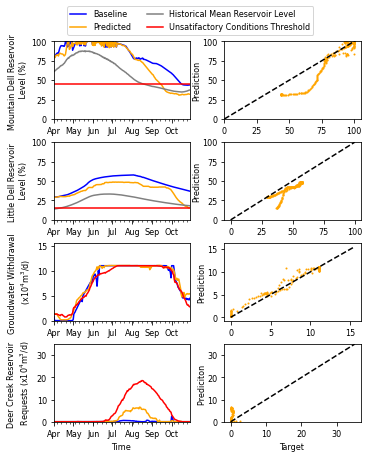

Ave_Clim
Making Predictions


prediction time 2 s
Predictions Complete
Ave_Clim Mountain Dell RMSE:  3.1774996278426446 %, MAPE:  3.709571072479236 %, R2:  0.9668105793902683
Ave_Clim Little Dell RMSE:  2.859222555690271 %, MAPE:  3.618745009139144 %, R2:  0.974194941330383
Ave_Clim GW Extraction RMSE:  1.016524 x10^4 m^3, MAPE:  16.85619354248047 %, R2:  0.9240858666127816
Ave_Clim DC Extraction RMSE:  1.8371964 x10^4 m^3, MAPE:  18.105836868286133 %, R2:  0.9482277329387895
Processing results to compare to historical observations


100% |########################################################################|


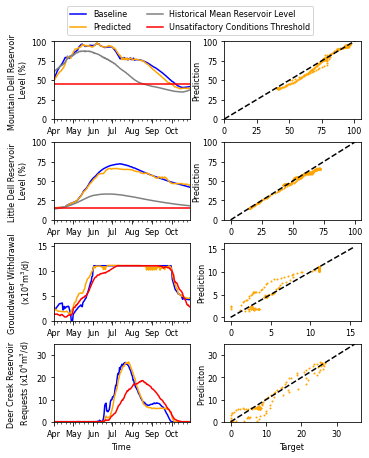

Dry_Clim
Making Predictions


prediction time 2 s
Predictions Complete
Dry_Clim Mountain Dell RMSE:  4.407922952124595 %, MAPE:  4.038162279314864 %, R2:  0.9435698831381003
Dry_Clim Little Dell RMSE:  4.4867764314035385 %, MAPE:  17.09369361631042 %, R2:  0.36203339437632676
Dry_Clim GW Extraction RMSE:  1.3148018 x10^4 m^3, MAPE:  23.299362182617188 %, R2:  0.9053354021457957
Dry_Clim DC Extraction RMSE:  2.2397366 x10^4 m^3, MAPE:  18.59767723083496 %, R2:  0.9555839929543191
Processing results to compare to historical observations


100% |########################################################################|


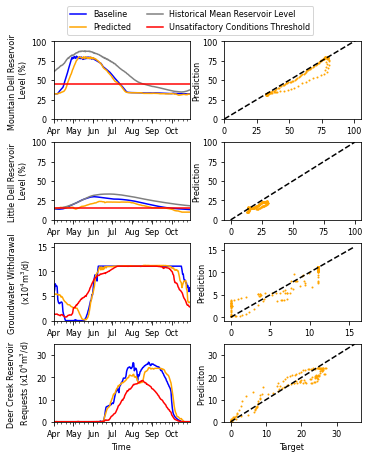

SLCDPU_GW  Vulnerability Breaks:  [0.0, 0.4, 0.53, 0.64]
SLCDPU_GW  Severity Breaks:  [0.0, 0.33, 0.67, 1.0]
SLCDPU_DC_Water_Use  Vulnerability Breaks:  [0.0, 0.09, 0.31, 0.61]
SLCDPU_DC_Water_Use  Severity Breaks:  [0.0, 0.21, 0.62, 1.0]
Mtn_Dell_Percent_Full  Vulnerability Breaks:  [0.0, 0.54, 0.83, 0.89]
Mtn_Dell_Percent_Full  Severity Breaks:  [0.0, 0.1, 0.84, 1.0]
LittleDell_Percent_Full  Vulnerability Breaks:  [0.0, 0.52, 0.6, 0.73]
LittleDell_Percent_Full  Severity Breaks:  [0.0, 0.23, 0.68, 1.0]


In [7]:


for clim in Predictions:
    ClimateScen = clim
    print(ClimateScen)
    print('Making Predictions')
    Predictions[clim] = ScenarioPredictor(features, targets, ClimateScen ) 
    #PredictionPerformancePlot(Analysis, ClimateScen)
    print('Processing results to compare to historical observations')
    Predictions[clim] = ForecastDataPrep(Predictions[clim], Hist_targs, evalyear,MDell_Thresh, LDell_Thresh)
    PredHistPerfPlot(Predictions[clim], ClimateScen)
    
    
#Find the historical daily values for the water system
Hist, Historical_Max_Daily_MDell, Historical_Max_Daily_LDell, Historical_Max_Daily_GW, Historical_Max_Daily_DC = Hist_Analysis(Predictions, Sims, simyears,MDell_Thresh,  LDell_Thresh )


Target_RRV = RRV_Assessment(Predictions, Hist, simyears, evalyear, Target_RRV)

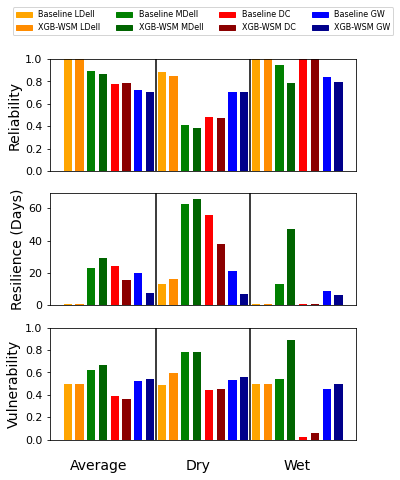

In [8]:
RRV_Plots(Target_RRV, 'Figures/WaterSystemRRV2.pdf')

In [911]:
Target_RRV['Mtn_Dell_Percent_Full'][-6:]

,Model,Climate,Target,Reliability,Resilience,Vulnerability,MaxSeverity,Maximum_Severity,Jenks_Vul,Jenks_Sev
80,SLC_WSM,Wet_Clim,Mtn_Dell_Percent_Full,0.943662,13.0,0.544147,1.550000,0.110163,medium,medium
84,XGB_WSM,Wet_Clim,Mtn_Dell_Percent_Full,0.784038,47.0,0.885674,14.319653,1.017744,high,NaN
88,SLC_WSM,Ave_Clim,Mtn_Dell_Percent_Full,0.896714,23.0,0.622243,4.500000,0.319829,medium,medium
92,XGB_WSM,Ave_Clim,Mtn_Dell_Percent_Full,0.868545,29.0,0.666037,6.074677,0.431747,medium,medium
96,SLC_WSM,Dry_Clim,Mtn_Dell_Percent_Full,0.413146,63.0,0.780189,12.810000,0.910448,medium,high
100,XGB_WSM,Dry_Clim,Mtn_Dell_Percent_Full,0.384977,66.0,0.784985,14.407967,1.024020,medium,NaN


In [912]:
Target_RRV['LittleDell_Percent_Full'][-6:]

,Model,Climate,Target,Reliability,Resilience,Vulnerability,MaxSeverity,Maximum_Severity,Jenks_Vul,Jenks_Sev
81,SLC_WSM,Wet_Clim,LittleDell_Percent_Full,1.000000,1.0,0.500000,0.00000,0.000000,low,low
85,XGB_WSM,Wet_Clim,LittleDell_Percent_Full,1.000000,1.0,0.496381,0.00000,0.000000,low,low
89,SLC_WSM,Ave_Clim,LittleDell_Percent_Full,1.000000,1.0,0.499085,0.00000,0.000000,low,low
93,XGB_WSM,Ave_Clim,LittleDell_Percent_Full,1.000000,1.0,0.499052,0.00000,0.000000,low,low
97,SLC_WSM,Dry_Clim,LittleDell_Percent_Full,0.882629,13.0,0.487907,1.70000,0.231230,low,medium
101,XGB_WSM,Dry_Clim,LittleDell_Percent_Full,0.849765,16.5,0.644569,7.74718,1.053751,high,NaN


In [913]:
Target_RRV['SLCDPU_GW'][-6:]

,Model,Climate,Target,Reliability,Resilience,Vulnerability,MaxSeverity,Maximum_Severity,Jenks_Vul,Jenks_Sev
82,SLC_WSM,Wet_Clim,SLCDPU_GW,0.840376,8.750000,0.452077,1.830855,0.178281,medium,low
86,XGB_WSM,Wet_Clim,SLCDPU_GW,0.798122,6.285714,0.493267,2.623986,0.255514,medium,low
90,SLC_WSM,Ave_Clim,SLCDPU_GW,0.723005,20.000000,0.519215,2.819797,0.274581,medium,low
94,XGB_WSM,Ave_Clim,SLCDPU_GW,0.708920,7.875000,0.541192,2.907979,0.283168,high,low
98,SLC_WSM,Dry_Clim,SLCDPU_GW,0.708920,21.000000,0.531235,6.146961,0.598567,high,medium
102,XGB_WSM,Dry_Clim,SLCDPU_GW,0.704225,7.111111,0.557944,4.186932,0.407707,high,medium


In [914]:
Target_RRV['SLCDPU_DC_Water_Use'][-6:]

,Model,Climate,Target,Reliability,Resilience,Vulnerability,MaxSeverity,Maximum_Severity,Jenks_Vul,Jenks_Sev
83,SLC_WSM,Wet_Clim,SLCDPU_DC_Water_Use,1.000000,1.000000,0.008853,0.000000,0.000000,low,low
87,XGB_WSM,Wet_Clim,SLCDPU_DC_Water_Use,1.000000,1.000000,0.046095,0.000000,0.000000,low,low
91,SLC_WSM,Ave_Clim,SLCDPU_DC_Water_Use,0.774648,24.500000,0.376511,16.669575,0.646979,high,high
95,XGB_WSM,Ave_Clim,SLCDPU_DC_Water_Use,0.784038,15.666667,0.349755,15.046016,0.583965,high,medium
99,SLC_WSM,Dry_Clim,SLCDPU_DC_Water_Use,0.478873,56.000000,0.436894,13.380265,0.519314,high,medium
103,XGB_WSM,Dry_Clim,SLCDPU_DC_Water_Use,0.474178,37.666667,0.441230,15.266670,0.592529,high,medium
